<a href="https://colab.research.google.com/github/morganLantrade/Projets_machine_learning/blob/main/projet_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/morganLantrade/Projets_machine_learning/tree/main/Projet_anti-spam" target="_parent"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" alt="Open In Colab" width="70" height="70" style="float:left; padding: 10px; "></a>
# MLP : Multi-Layer Perceptron 

## Fonctionnement d'un MLP sur un échantillon

<a href="https://www.researchgate.net/figure/Multilayer-perceptron-MLP-architecture-with-two-hidden-layers-and-one-prediction-output_fig1_349630467"><img src="https://www.researchgate.net/publication/349630467/figure/fig1/AS:995457505447936@1614346972386/Multilayer-perceptron-MLP-architecture-with-two-hidden-layers-and-one-prediction-output.png" alt="Multilayer perceptron (MLP) architecture with two hidden layers and one prediction output." target="_blank"/></a>

## Fonctionnement d'un neurone d'une couche d'un perceptron

<a href="https://www.researchgate.net/figure/La-structure-dun-neurone-artificiel_fig3_303447451"><img src="https://www.researchgate.net/profile/Safae-Laqrichi/publication/303447451/figure/fig3/AS:644326015123459@1530630701780/La-structure-dun-neurone-artificiel.png" alt="3-La structure d'un neurone artificiel" target="_blank"/></a>

#### Importations

In [1]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_circles

warnings.filterwarnings('ignore')

### Fonctions d'activation

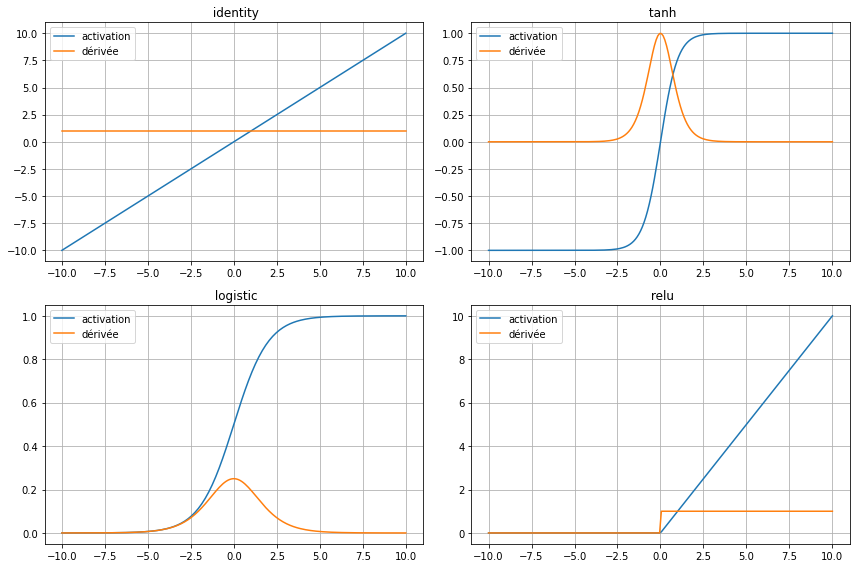

In [2]:
def identity(Z):
    return Z

def d_identity(A):
    return np.ones((A.shape))

def sigmoide(Z):
    return 1/(1+np.exp(-Z))

def d_sigmoide(A):
    return A*(1-A)

def tanh(Z): 
    return (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))

def d_tanh(A):
    return 1-A*A

def relu(Z):
    return np.where(Z>0,Z,0)

def d_relu(A):
    return np.where(A>0,1,0)


ACTIVATIONS={'identity' : (identity,d_identity) ,'logistic' : (sigmoide,d_sigmoide),
             'tanh': (tanh,d_tanh),'relu': (relu,d_relu)}

def afficherActivations(activations):
    i=0
    x=np.linspace(-10,10,200)
    fig, axs = plt.subplots(2,2)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    for nom,a in activations.items():
        axs[i%2,i//2].plot(x,a[0](x),label='activation')
        axs[i%2,i//2].plot(x,a[1](a[0](x)),label='dérivée')
        axs[i%2,i//2].set_title(f' {nom}')
        axs[i%2,i//2].legend()
        axs[i%2,i//2].grid(True)
        i+=1
    fig.tight_layout()
afficherActivations(ACTIVATIONS)


        

<div class="alert alert-block alert-info">
<b>Remarque:</b> La liste d'activations est non éxhaustive et le choix de l'activation dépend du type de problème ( régression , classification ( binaire / multiclasse ) , ...
On commençera par implémenter avec la fonction sigmoïde et on essayera pour une classification binaire des couches cachées différentes et garder la derniere couche sigmoïde (pour finir entre 0 et 1).</div>

### Fonctions coût 

$$\begin{alignat}{2} L_{MSE}=& \frac{1}{m}.\sum_{k=1}^{m} (y_k-a_k)^2\\
L_{log\_loss}=& -\frac{1}{m}.\sum_{k=1}^{m} y_{k}.ln(a_{k})+(1-y_k).ln(1-a_k)\\
\end{alignat}$$

### Dérivées coût

$$\begin{alignat}{2} 
\frac{\partial L_{MSE}}{\partial a_k}=& \frac{2}{m}.\sum_{k=1}^{m} (a_k-y_k)\\
\frac{\partial L_{log\_loss}}{\partial a_k} =& \frac{1}{m}.\sum_{k=1}^m \frac{a_k-y_k}{a_k(1-a_k)})\\
\end{alignat}$$

In [3]:
def MSE_cost(A,y):
    return 1/y.shape[1]*np.sum((y-A)**2)

def log_loss(A,y,eps=10**(-15)):  #eps car log n'est pas définie en 0
    return - 1/y.shape[1]* np.sum(y *np.log(A+eps) + (1 - y) * np.log(1-A+eps))

def d_MSE_cost(A,y): #la somme 1 à m sera faite en produit matriciel (m,n)
    return 2/y.shape[1]*(A-y)

def d_log_loss(A,y,eps=10**(-15)): #la somme de 1 à m sera faite en produit matriciel avec (m,n)
    return 1/y.shape[1]*(A+eps-y)/((A+eps)*(1-A+eps))

COSTS={ 'log_loss':(log_loss,d_log_loss),'MSE': (MSE_cost,d_MSE_cost)}

### Formes de nos données vectorisées pour une couche l:
- m échantillons 
- $n^{[l-1]}$ variables  en entrée 
- $n^{[l]}$ en sortie 

$$\begin{alignat}{2} A^{[0]}= X = & \underbrace{\begin{bmatrix}
x_{1,1} & x_{1,2}&...& x_{1,m}\\
... &  ...&   ...&   ...&\\
x_{n^{[0]},1} & x_{n^{[0]},2}&...& x_{n^{[0]},m}\\
\end{bmatrix}}_{(n^{[0]},m)}\\
Y = & \underbrace{\begin{bmatrix}
y_{1} & y_{2} &... &y_{m}\end{bmatrix}}_{(1,m)}\\
W^{[l]} = & \underbrace{\begin{bmatrix}w^{[l]}_{1,1} & w^{[l]}_{1,2} &... &w^{[l]}_{1,n^{[l-1]}}\\
... & ... &... &... \\
w^{[l]}_{n^{[l]},1} & w^{[l]}_{n^{[l]},2} &... &w^{[l]}_{n^{[l]},n^{[l-1]}}\\
\end{bmatrix}}_{(n^{[l]},n^{[l-1]})} & B^{[l]}= \underbrace{\begin{bmatrix}
b^{[l]}_{1}\\
...\\
b^{[l]}_{n^{[l]}}\end{bmatrix}}_{(n^{[l]},1)}
\end{alignat}$$

<div class="alert alert-block alert-info">
<b>Remarque :</b>  Pour une simplication de notre vectorisation nous inclurons une ligne de 1 dans X et une colonne de b dans W.</div>

### Forward propagation 

$$
\forall l \in \{1,...,L\} : couches\\
\forall j \in \{1,...,n^{[L]}\} : neurones\\
\forall k \in \{1,...,m\} : échantillons
$$ 

$$\begin{alignat}{2} z^{[l]}_{jk} = & \sum_{i=1}^{n^{[l-1]}} w^{[l]}_{ji}.a^{[l-1]}_{ik} + b_j^{[l]}\\
\newline
\underbrace{Z}_{(n^{[l]},m)}^{[l]}  = & \begin{bmatrix}
\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{i,1} + \color{blue}b_1^{[l]} &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{i,2} + \color{blue}b_1^{[l]} &, &... &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{im} + \color{blue}b_1^{[l]}\\
... &,  &... &, &... &,  & ...\\
\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,1} + \color{blue}b^{[l]}_{n^{[l]}} &, &\sum_{i=1}^{n^{[l-1]}}\color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,2} + \color{blue}b^{[l]}_{n^{[l]}} &, &... &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,m} + \color{blue}b^{[l]}_{n^{[l]}}\\
\end{bmatrix}\\
\newline
\underbrace{Z}_{(n^{[l]},m)}^{[l]} = &\color{red}{\underbrace{{\begin{bmatrix}w^{[l]}_{1,1} & w^{[l]}_{1,2} &{...} &w^{[l]}_{1,n^{[l-1]}}\\
... & ... &... &... \\
w^{[l]}_{n^{[l]},1} & w^{[l]}_{n^{[l]},2} &{...} &w^{[l]}_{n^{[l]},n^{[l-1]}} \\
\end{bmatrix}}}_{(n^{[l]},n^{[l-1]})}}.\color{green}{\underbrace{\begin{bmatrix}
a^{[l-1]}_{1,1} & a^{[l-1]}_{1,2}&...& a^{[l-1]}_{1,m}\\
... &  ...&   ...&   ...&\\
a_{n^{[l-1]},1} & a^{[l-1]}_{n^{[l-1]},2}&...& a^{[l-1]}_{n^{[l-1]},m}\\
\end{bmatrix}}_{(n^{[l-1]},m)}}+\color{blue}{\underbrace{\begin{bmatrix}
b^{[l]}_1& ...& b^{[l]}_1\\
{...}& ...& ...\\
b^{[l]}_{n^{[l]}}& ...& b^{[l]}_{n^{[l]}} \end{bmatrix}}_{(n^{[l-1]},m)}}\\
\underbrace{Z}_{(n^{[l]},m)}^{[l]} = & W^{[l]}.A^{[l-1]} + B^{[l]} \\
\newline
\underbrace{A}^{[l]}_{(n^{[l]},m)}= &\frac{1}{1+e^{-Z^{[l]}}}
\end{alignat}$$

<div class="alert alert-block alert-success">
On obtient les activations où les lignes correspondent aux neurones et colonnes aux échantillons.</div>


<div class="alert alert-block alert-info">
<b>Remarque 1:</b> Le produit matriciel nous permet de faire la somme de 1 a m pour obtenir la matrice Z.
    
<b>Remarque 2:</b> On peut réduire B à une seule colonne car numpy permet d'additionner toute une ligne selon un une valeur.</div>

### Backward propagation à L couches
- activation : <span style="color:green"> **sigmoide** </span> 
- cost : <span style="color:brown"> **MSE** </span>
- cost : <span style="color:purple"> **log_loss** </span>

#### Calcul des dérivées de la derniere couche L : 


$$
\begin{alignat}{5}
\require{cancel}
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})} &= &\color{red}{\frac{\partial L}{\partial A^{[L]}} }*\color{green}{\frac{\partial A^{[L]}}{\partial Z^{[L]}}}*\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}}_{(n^{[L-1]},m)} &= & A^{[L-1]}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[L]}}{\partial B^{[L]}}}}_{(n^{[L-1]},1)} &= & 1\\
&\color{red}{\frac{\partial L_{MSE}}{\partial a_{ji}^{[L]}}}&= & \frac{2}{m}*\sum_{i=1}^{m} (a_{ji}-y_i)\\
&\color{red}{\frac{\partial L_{log\_loss}}{\partial a_{ji}^{[L]}}}&= & \frac{1}{m}*\sum_{i=1}^m \frac{(a_{ji}-y_i)}{a_{ji}(1-a_{ji})}\\
&\color{green}{\underbrace{\frac{\partial a^{[L]}_{ji}}{\partial z^{[L]}}}_{(n^{[L]},m)}}&= & a^{[L]}_{ji}*(1-a^{[L]}_{ji})\\
&\color{purple}{\frac{\partial L_{MSE}}{\partial {z_{ji}}^{[L]}}}& =&\color{red}{\frac{\partial L}{{\partial a^{[L]}_{ji}}} }*\color{green}{\frac{{\partial a^{[L]}_{ji}}}{\partial {z_{ji}}^{[L]}}}= \color{red}{\frac{2}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)*\color{green}{a^{[L]}_{ji}*(1-a^{[L]}_{ji})}}\\
&\color{brown}{\frac{\partial L_{log\_loss}}{\partial {z_{ji}}^{[L]}}}& =&\color{red}{\frac{\partial L}{\cancel{\partial a^{[L]}_{ji}}} }*\color{green}{\frac{\cancel{\partial a^{[L]}_{ji}}}{\partial {z_{ji}}^{[L]}}}= \color{brown}{\frac{1}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)}\\
\newline
\newline
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})}} &= &\boxed{\color{red}{\underbrace{2*(A^{[L]}-y)*\color{green}A^{\color{green}[\color{green}L\color{green}]}\color{green}*\color{green}(\color{green}1\color{green}-\color{green}A^{\color{green}[\color{green}L\color{green}]}\color{green})}_{(n^{[L]},m)}} .\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial B^{[L]}}}_{(n^{[L]},1)}} &= &\boxed{\color{red}{\frac{2}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)*\color{green}{a^{[L]}_{ji}*(1-a^{[L]}_{ji})}}}\\
\newline
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})}} &= &\boxed{\color{brown}{\underbrace{(A^{[L]}-y)}_{(n^{[L]},m)}} .\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial B^{[L]}}}_{(n^{[L]},1)}} &= &\boxed{\color{brown}{\frac{1}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)}}\\
\end{alignat}$$

<div class="alert alert-block alert-info">
<b>Même principe que la propagation avant :</b>
    
Le produit matriciel permet de vectoriser la somme de 1 à m .

Pour les gradients de B, numpy nous permet de faire la somme de chaque ligne. (axis=1)</div>



#### Calcul des dérivées de la couche l

$$
\begin{alignat}{5}
&{\underbrace{\frac{\partial L}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &{\frac{\partial L}{\partial Z^{[l]}}}*\color{blue}{\frac{\partial Z^{[l]}}{\partial W^{[l]}}}  \\
&{\frac{\partial L}{\partial Z^{[l]}}}& = &{\frac{\partial L}{\partial Z^{[l+1]}}}* \color{gray}{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}} *  \color{green}{\frac{\partial A^{[l]}}{\partial Z^{[l]}}} \\
& &=&\underbrace{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{{\frac{\partial L}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}}_{(n^{[l]},m)}\\
\newline
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &\boxed{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{\color{purple}{\frac{\partial L_{MSE}}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}.\color{blue}{\underbrace{{}^TA^{[l-1]}}_{(m,n^{[l-1]})}}}\\
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial B^{[l]}}}_{(n^{[l]},1)}} &=  &\boxed{\color{purple}{\sum _{k=0}^{m} \frac{\partial L_{MSE}}{\partial Z^{[l]}}}} \\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &\boxed{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{\color{brown}{\frac{\partial L_{log\_loss}}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}.\color{blue}{\underbrace{{}^TA^{[l-1]}}_{(m,n^{[l-1]})}}}\\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial B^{[l]}}}_{(n^{[l]},1)}} &=  &\boxed{\color{brown}{\sum _{k=0}^{m} \frac{\partial L_{log\_loss}}{\partial Z^{[l]}}}} \\
\end{alignat}$$

<div class="alert alert-block alert-success">
Nous avons réussi à exprimer les gradients de la couche L-1 par ceux de la couche L, nous pouvons donc maintenant récursivement
remonter jusqu a la couche 0.
Nous avons maintenant toutes les formules pour implémenter notre MLP avec une activation : sigmoïde et un cout : log_loss ou MSE.</div>


### Implémentation du modèle

In [4]:
def initParam(X,hidden_layer=[]):
    '''Retourne une liste des poids de notre modeles
       une liste des biais de notre modeles
       longueur = longueur hidden_layer + 1'''
    couches= [X.shape[0]]+hidden_layer+[1]
    coefs=[]
    biais=[]
    np.random.seed(1)
    for i in range(1,len(couches)):
        coefs.append(np.random.randn(couches[i],couches[i-1]))
        biais.append(np.random.randn(couches[i],1))
    return coefs,biais


def forwardPropagation(X,coefs,biais,activation='logistic',cost='log_loss'):
    '''Retourne une liste d'activations ou l'indice correspondant a la couche
    A[0]=X '''
    K=len(coefs)
    activations=[X]
    for i in range(1,K+1):
        W=coefs[i-1]
        b=biais[i-1]
        Z=W.dot(activations[i-1])+b
        A=ACTIVATIONS[activation][0](Z) if i!=K else sigmoide(Z) # on finit sur une sigmoide
        activations.append(A)
    return activations


def predict(X,coefs,bais,activation='logistic'):
    '''Seuil 0.5 pour la sigmoide'''
    A=forwardPropagation(X,coefs,bais,activation=activation)[len(coefs)] # derniere couche
    return np.where(A>0.5,1.,0.) 

def predict_proba(X,coefs,bais,activation='logistic'):
    A=forwardPropagation(X,coefs,bais,activation)[len(coefs)] # derniere couche
    return A


def backwardPropagation(X,y,coefs,biais,activations,activation='logistic',cost='log_loss'):
    '''Retourne une liste des gradients de W et de b ou 
    l'indice correspondant à la couche i-1
    '''
    K=len(coefs)
    m=X.shape[1]
    #nous allons devoir stocker les dL/dZ pour notre rétroPropagation 
    les_dZ= [COSTS[cost][1](activations[K],y) * ACTIVATIONS[activation][1](activations[K])] 
    #la premiere propagation arriere est sigmoide
    dWs= [les_dZ[0].dot(activations[K-1].T)]  
    dBs=[(1/m if cost=='log_loss' else 2/m) * np.sum(les_dZ[0],axis=1,keepdims=True)]
    for L in range(1,K):
        W=coefs[K-L]
        b=biais[K-L]
        A=activations[K-L]
        dZ= 1/m * (W.T).dot(les_dZ[L-1])*ACTIVATIONS[activation][1](A) #dérivée de la fonction activation
        les_dZ.append(dZ)
        dWs.insert(0,dZ.dot(activations[K-L-1].T))
        dBs.insert(0,np.sum(dZ,axis=1,keepdims=True))
    return dWs,dBs

def mAj(coefs,biais,dWs,dBs,alpha):
    for L in range(len(coefs)):
        coefs[L]=coefs[L]-alpha*dWs[L]
        biais[L]=biais[L]-alpha*dBs[L]
        
def learn_affichage(Xa,ya,Xt,yt,hidden_layer=[16,8,4],alpha=0.1, iter=200,bid=1,activation='logistic',cost='log_loss'):
    '''Fonction fit de notre modele qui mémorise les courbes d aprentissage'''
    coefs,biais=initParam(Xa,hidden_layer)
    stop=False
    k=0
    couts_A,couts_t,scores_A,scores_t=[],[],[],[]
    while k<iter:
        les_A=forwardPropagation(Xa,coefs,biais,activation,cost)
        dWs,dBs=backwardPropagation(Xa,ya,coefs,biais,les_A,activation,cost)
        mAj(coefs,biais,dWs,dBs,alpha)
        k+=1
        # pour diminuer le nombre de calculs
        if k%bid==0: 
            #sauvegarde des données pour le tracé des courbes d'apprentissages et de loss
            couts_A.append(COSTS[cost][0](les_A[len(coefs)],ya))
            couts_t.append(COSTS[cost][0](forwardPropagation(Xt,coefs,biais,activation,cost)[len(coefs)],yt))
            scores_A.append(accuracy_score(ya[0],predict(Xa,coefs,biais,activation)[0]))
            scores_t.append(accuracy_score(yt[0],predict(Xt,coefs,biais,activation)[0]))
           
            
    return coefs,biais,couts_A,couts_t,scores_A,scores_t

def afficherApprentissage(couts_A,couts_t,scores_A,scores_t,bid=1,W=[],b=[],Xa=[],Xt=[],ya=[],yt=[],activation='logistic'):
    '''Fonction d'affichage de l"apprentrissage '''
    X= [ x*bid for x in range(len(couts_A))] #nombre d'itérations
    fig, axs = plt.subplots(1,(2 if not W else 3)) #cas classification binaire
    fig.set_figheight(5)
    fig.set_figwidth(18)
    axs[0].plot(X,couts_A,label='loss apprentissage')
    axs[0].plot(X,couts_t,label='loss test')
    axs[0].set_title('Loss curve')
    axs[0].set_xlabel('itérations')
    axs[0].set_ylabel('cost')
    axs[0].legend()
    axs[1].plot(X,scores_A,label='score apprentissage')
    axs[1].plot(X,scores_t,label='score test')
    axs[1].set_title(f'Learning curve')
    axs[1].set_xlabel('itérations')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    if W:
        cmp = np.array(['g','b'])
        axs[2].scatter(Xa[0,:],Xa[1,:],c=ya[0],s=50,alpha=0.2)
        axs[2].scatter(Xt[0,:],Xt[1,:],c=yt[0],s=50)
        nx, ny = 200, 200
        x_min, x_max = axs[2].get_xlim()
        y_min, y_max = axs[2].get_ylim()
        xx, yy = np.meshgrid(np.linspace(x_min,x_max, nx),np.linspace(y_min,y_max, ny))
        axs[2].set_title(f'Frontiere')
        Z = predict_proba(np.c_[xx.ravel(), yy.ravel()].T,W,b,activation)
        Z=Z[0, :].reshape(xx.shape)
        # dessiner le contour correspondant à la frontière proba = 0,5
        plt.contourf(xx, yy, Z, [0,0.5,1],colors=['rosybrown','papayawhip'])
        plt.scatter(Xa[0,:],Xa[1,:],c=ya[0],s=50,alpha=0.2)
        plt.scatter(Xt[0,:],Xt[1,:],c=yt[0],s=50)
 




### Testons sur une classification binaire 

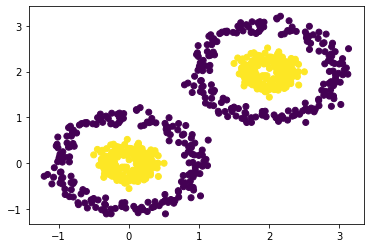

In [5]:
Xa, ya = make_circles(n_samples=400, noise=0.10, factor=0.3, random_state=0)
Xa=np.concatenate((Xa,Xa+2))
Xt, yt = make_circles(n_samples=100, noise=0.10, factor=0.3, random_state=0)
Xt=np.concatenate((Xt,Xt+2))
Xa =Xa.T
Xt=Xt.T
ya=np.concatenate((ya,ya))
yt=np.concatenate((yt,yt))
ya = ya.reshape(ya.shape[0])

plt.scatter(Xa[0, :], Xa[1, :], c=ya)
plt.show()
ya = ya.reshape(1,ya.shape[0])
yt = yt.reshape(1,yt.shape[0])



### Une couche : Un neurone

###### MSE

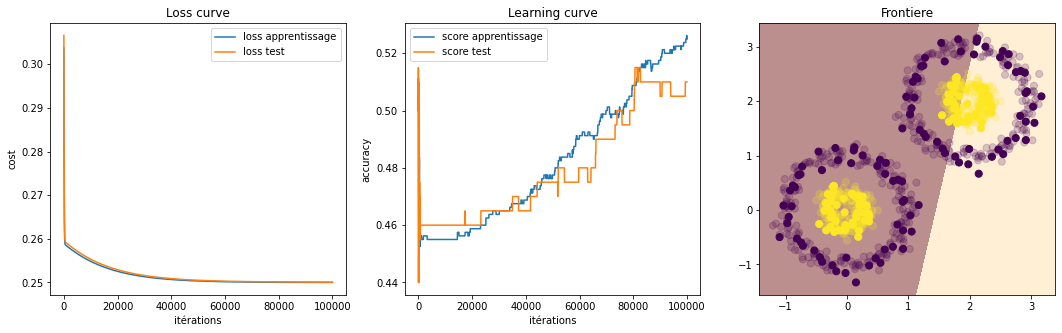

In [6]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[],0.2,100000,10,cost='MSE')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt)

###### log_loss

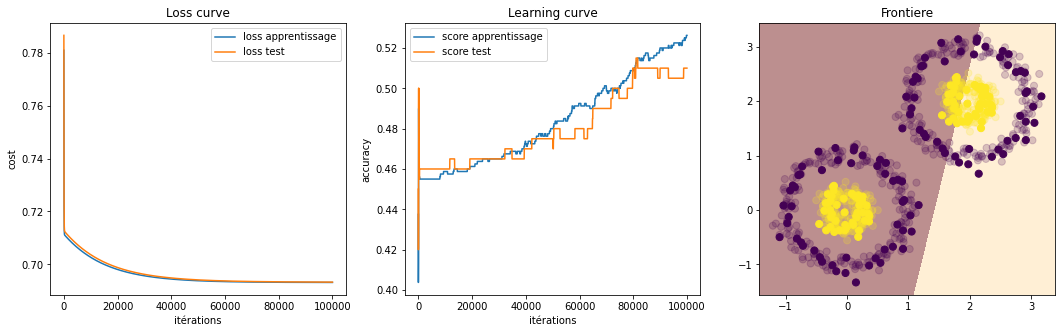

In [7]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[],0.2,100000,10,cost='log_loss')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt)

<div class="alert alert-block alert-warning">
On essaye de séparer linéairement : impossible
</div>

#### Deux couches : Plusieurs neurones

##### 32 neurones , MSE, logistic

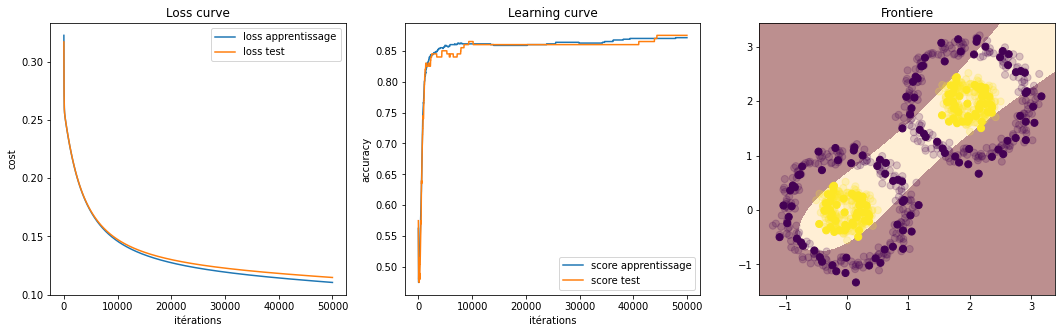

In [8]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[32],0.2,50000,10,cost='MSE',activation='logistic')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'logistic')

#### 32 neurones , log_loss, logistic

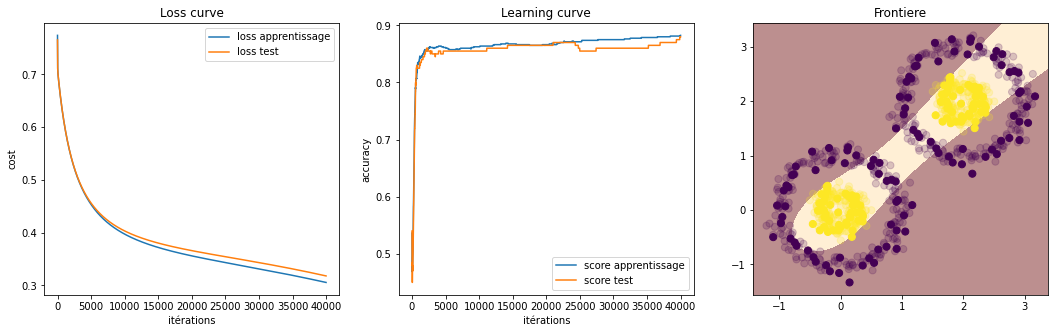

In [9]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[32],0.2,40000,10,cost='log_loss',activation='logistic')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'logistic')

##### 32 neurones , MSE , relu

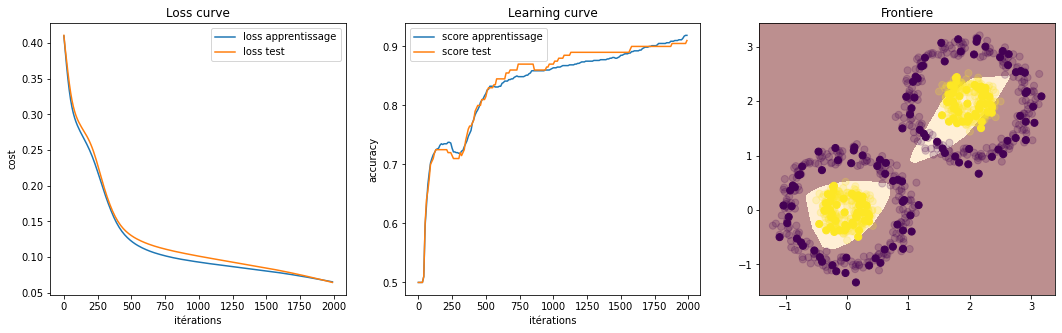

In [10]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[32],0.2,2000,10,cost='MSE',activation='relu')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'relu')

##### 32 neurones , log_loss , relu

[ 1.41209130e+14  1.80396112e+08  1.21421981e+10 -2.25935152e+15
  1.43796505e+14 -3.95527410e+09 -7.06471559e-01 -1.69838773e+13
 -2.53560025e+10 -1.24896906e+15 -1.39388214e+14  4.16563030e+13
  1.57000885e+13  1.33866321e+09  4.21991242e+13  1.61170940e+09
  2.25289640e+10 -1.92165297e+10  1.21005694e+09  3.27473311e+14
 -4.84030111e+08  1.10622376e+14  1.80320588e+09 -3.00801712e+15
 -9.50063365e+14  6.70418273e+13  6.07506378e+09 -5.43330572e+14
  1.92172736e+14 -1.06649132e+15 -7.69449852e+14 -3.62527330e+14]
[-1.24649339e+16]


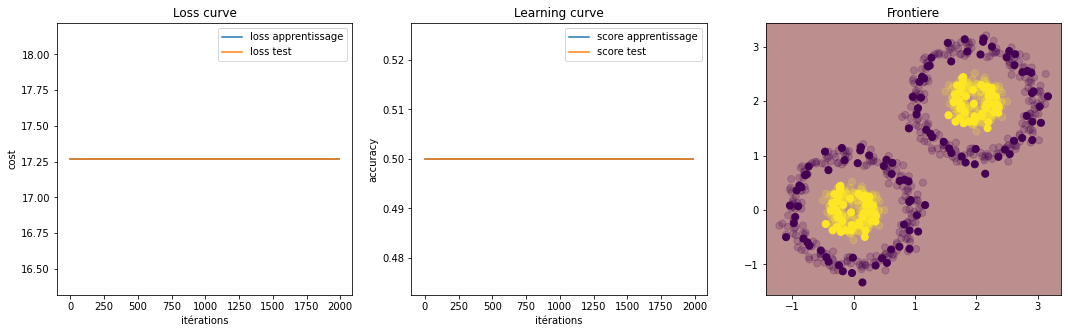

In [11]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[32],0.2,2000,10,activation='relu',cost='log_loss')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'relu')
for w in W:
    print(np.sum(w,axis=1))

<div class="alert alert-block alert-warning">
Explosion des poids</div>

##### 64 neurones , MSE, relu

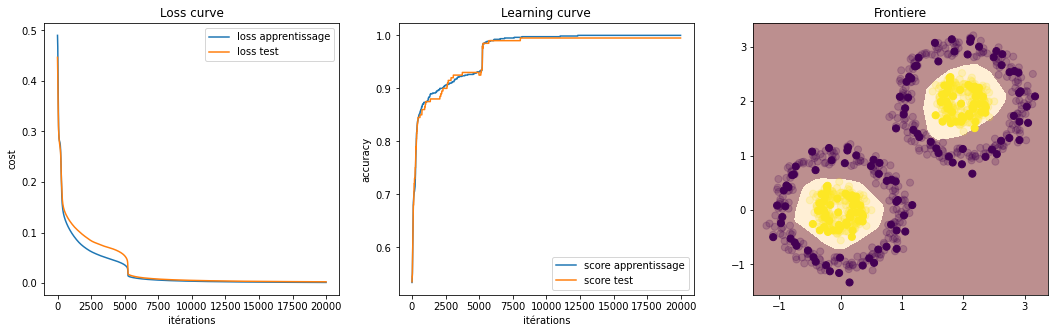

In [12]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[64],0.2,20000,10,activation='relu',cost='MSE')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'relu')

##### 8x8 neurones , MSE, relu

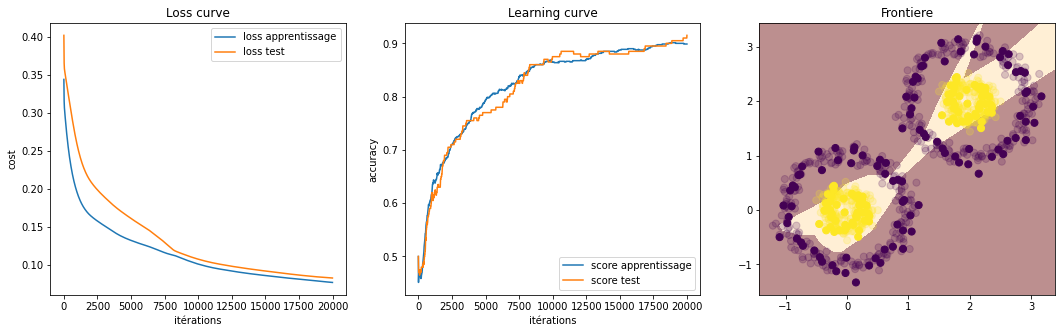

In [13]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[8,8],0.2,20000,10,activation='relu',cost='MSE')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'relu')

##### 16x16 neurones , MSE, logistic

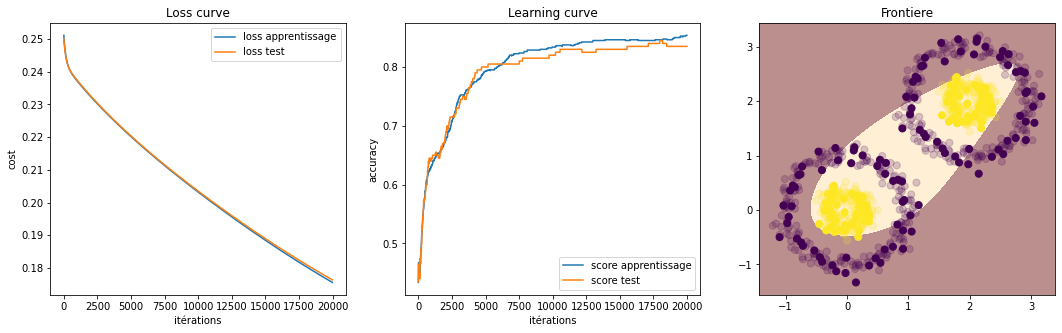

In [14]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[16,16],0.2,20000,10,activation='logistic',cost='MSE')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'logistic')

##### 16x16 neurones , MSE, relu

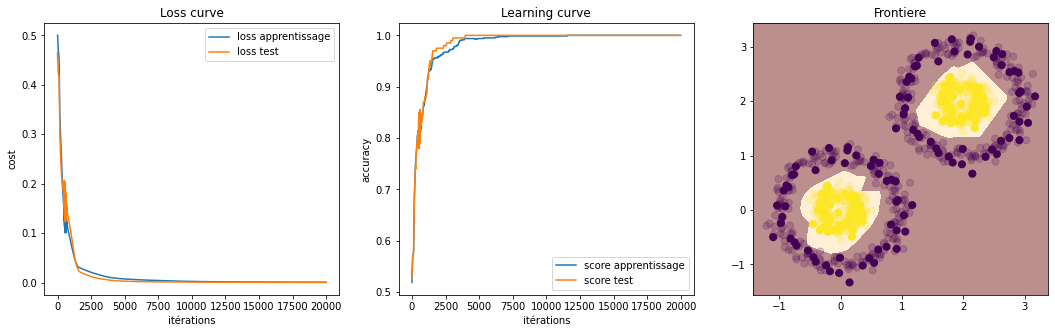

In [15]:
W,b,cA,ct,sA,st= learn_affichage(Xa,ya,Xt,yt,[16,16],0.2,20000,10,activation='relu',cost='MSE')
afficherApprentissage(cA,ct,sA,st,10,W,b,Xa,Xt,ya,yt,'relu')

<div class="alert alert-block alert-success">
[SUITE]...</div>